In [1]:
from network import Network
from keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

Using TensorFlow backend.


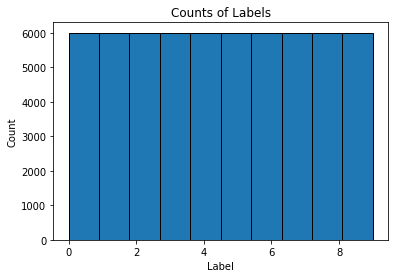

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.hist(y_train[:], edgecolor = 'k'); 
plt.xlabel('Label'); plt.ylabel('Count'); plt.title('Counts of Labels');

In [3]:
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [3]:
# let's print the shape before we reshape and normalize
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

# building the input vector from the 28x28 pixels
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing the data to help with the training
X_train /= 255
X_test /= 255

# print the final input shape ready for training
print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)
Train matrix shape (60000, 784)
Test matrix shape (10000, 784)


In [4]:
from sklearn.metrics import roc_auc_score
from timeit import default_timer as timer
start = timer()
network = {'nb_layers':1, 'nb_neurons':784, 'activation':'relu','optimizer':'adam'}
model = Network(network, nb_classes=10, input_shape=(X_train.shape[1],),gpus=1)
results = model.cross_validate_model(X_train, y_train,num_folds=5)
train_time = timer() - start

print('The baseline score on the test set is {:.4f}.'.format(results))
print('The baseline training time is {:.4f} seconds'.format(train_time))

W0625 18:55:36.357119 139803109599040 deprecation_wrapper.py:119] From /home/zander/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0625 18:55:36.370257 139803109599040 deprecation_wrapper.py:119] From /home/zander/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0625 18:55:36.371856 139803109599040 deprecation_wrapper.py:119] From /home/zander/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0625 18:55:36.383249 139803109599040 deprecation_wrapper.py:119] From /home/zander/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v

12000/12000 [==============================] - 0s 17us/step
The baseline score on the test set is 0.9390.
The baseline training time is 20.4218 seconds


In [5]:
import csv
import sys
from hyperopt import STATUS_OK

def objective(params, n_folds = 5):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    sys.stdout.flush()
    start = timer()
    #When using Hyperpot to generate our lists, it creates them as floats, to we are converting them to
    #integers so that they will work on our Neural Network
    for parameter_name in ['nb_neurons', 'nb_layers']:
        params[parameter_name] = int(params[parameter_name])
    #Create and compile our network, from the parameters that the TPE choses. 
    model = Network(network, nb_classes=10, input_shape=(X_train.shape[1],),gpus=1)
    cv_results = model.cross_validate_model(X_train, y_train,num_folds=5)
    #This allows us to keep track of how long it takes to run the 5 fold CV on our NN.
    #This is important if we need to make comprimises on speed VS accuracy.
    #The more nodes/layers that you have, the longer it takes for the NN to train/run
    run_time = timer() - start
    
    # We take 1 - our accuracy to get how far away our model is from 100% accuracy. 
    loss = 1 - cv_results

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([cv_results, params, ITERATION, run_time])
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}

In [6]:
from hyperopt import tpe
from hyperopt import Trials
from hyperopt import fmin
from hyperopt import hp

# optimization algorithm
tpe_algorithm = tpe.suggest

# Keep track of results
bayes_trials = Trials()
# Define the search space
space = {
    'nb_layers': hp.quniform('nb_layers', 1,7, 1), #Layers from 1-5, incrementing by 1
    'nb_neurons': hp.quniform('nb_neurons', 64, 1024, 32), #NB neurons from 64-1024, incrementing by 64
    'activation': hp.choice('activation', ['relu', 'elu', 'tanh', 'sigmoid']), #Chose one of the 4 activations functions for the layers
    'optimizer': hp.choice('optimizer', ['rmsprop', 'adam', 'sgd', 'adagrad',
                      'adadelta', 'adamax', 'nadam']) #Chose one of the 7 optimizers
}

In [7]:
#Here we can see what a random sample from our space looks like
from hyperopt.pyll.stochastic import sample
sample(space)

{'activation': 'elu',
 'nb_layers': 5.0,
 'nb_neurons': 320.0,
 'optimizer': 'adam'}

In [8]:
# File to save first results
out_file = './neural_network.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['accuracy', 'params', 'iteration', 'train_time'])
of_connection.close()

In [10]:
%%capture

# Global variable
global  ITERATION
import numpy as np
ITERATION = 0
# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = 25, trials = bayes_trials, rstate = np.random.RandomState(50))